# Leveraging Large Language Models for Intelligent Claim Handling: A Hands-On Industry Case Study

## What is RAG exactly?

Retrieval-augmented generation is the idea of using langage model to summarize of pieces of information, plus reasonning (to some extend) in order to answer a query. It differs from classical generation in the sense that the model is not supposed to rely on its internal knowledge, but additional information, retrieved dynamically depending on the request as context in addition to the initial prompt, to answer the user query.

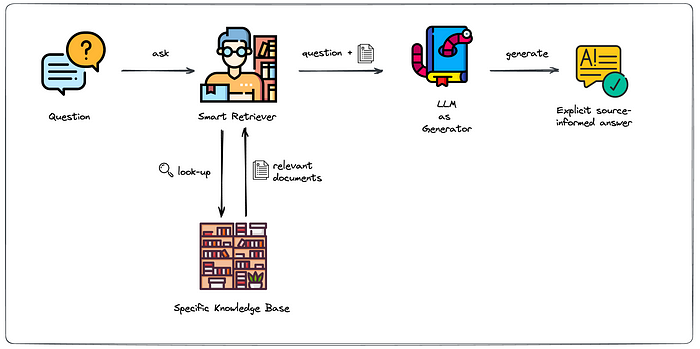

## Why is this approach actually interesting?

Even if Deepseek claims to have trained a model for less than $6 milion, it remains too costly for people like me or companies like AXA to train a language model to solve a specific task.

Aside from the price tag, the following aspects make RAG engaging compared to direct generation:

- generic LLMs are not expected to know anything about specific insurance contracts and often get mixed-up because of the size of the training data → to limit the hallucinations, the information source must be specific & narrow

- Information required to answer questions is often disseminated across documents or sections of single file, and likely to be larger than Gemini 1M context window (~250k words)
→ information needs to be selected/curated

- Some addendum might be added after the initial creation of the contract and new insurance products are constantly being created, replacing the old ones → flexibility of the information sources, the system must stay up-to-date with the latest changes

- Being able to fact-check an answer is always great, especially when pontentially very large amount of money are one the line → transparency on the sources is pretty much a must

## The key elements of a basic RAG system

A RAG system can be decomposed into two elements; the retrieval and the generation module, which can respectively be further decomposed;

### The retrieval module; aka the memory

The retrieval module is responsible for finding relevant pieces of information stored in a knowledge database in order to answer a given query with more accuracy.

Vector databases are typically used as knowledge database and **store each piece of information (text) with a vector representation of its content**.

The vectors are obtained using embedding models, which project long sequence of tokens into a latent space capturing their semantic meaning.

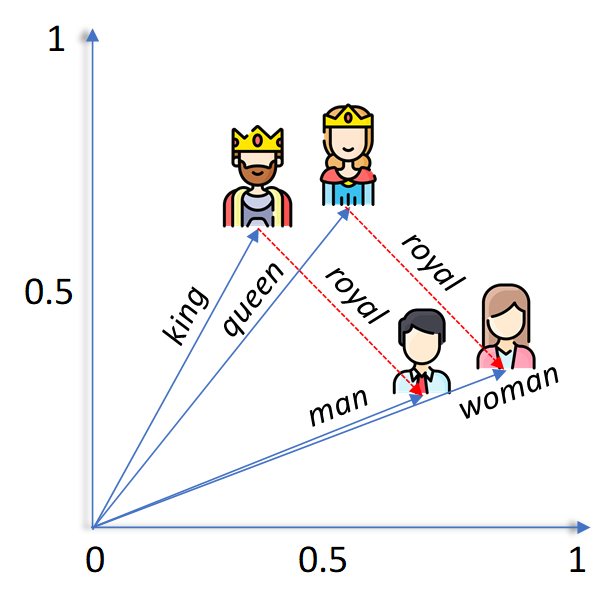

Hence, prior to exposing the system to users, the relevant documents (in this context, an insurance contract) must be processed (parsed & chunked) before going through the embedding model and finally being stored in the vector database.

When a user is sending a query, its embedding vector is generated using the same embedding model and compared with the entries in the knowledge databse using a similarity fonction such as the cosine similarity or squared L2 norm.

In some case, using hybrid approaches to retrieve the relevant chunks; for example vectors + keywords search can give much better results!

### Generation module; aka the brain

This is where the interaction with the langage model can be found. In addition to the traditional system prompt, it is also in charge of combining the retrieved context with the user query in a way that makes it easy for the model to extract the useful information.

**Notes:** In order to get better performance, more logic can be added to the retrieval and the generation such as:
- query augmentation
- relevant chunks reranking
- agentic completion
- and so much more!

## Time to implement all these implement from (almost) scratch!


In [25]:
%%capture
# clone the repo, install dependencies,
!git clone https://github.com/unit8co/AMLD2025.git
!curl -LsSf https://astral.sh/uv/install.sh | sh
!/root/.local/bin/uv pip install --system -r AMLD2025/pyproject.toml

In [26]:
!/root/.local/bin/uv pip install --system chromadb mistralai

Using Python 3.11.11 environment at: /usr
Resolved 92 packages in 58ms
Uninstalled 1 package in 1ms
Installed 1 package in 2ms
 - protobuf==3.20.3
 + protobuf==5.29.3


In [27]:
import re
import json
import random
import chromadb
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from openai import OpenAI
from mistralai import Mistral
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix


In [28]:
#API_KEY = userdata.get('OPENAI_API_KEY') or userdata.get('MISTRAL_API_KEY')
API_KEY = "77JGe8P4sWsujieVQ5EwP0lY6dVVd57c"

Because you probably all already know how to do it, we'll directly use a parsed version of the contract as markdown;

In [29]:
# =====================================
# Processing Module
# =====================================
class ProcessingModule:
    def __init__(self, chunk_size: int, chunk_overlap: int):
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap

    def split_document(self, document: str) -> list[dict[str, str]]:
        """Split parsed document into chunks

        Hint: to improve the quality of the context, it's always better to have chunks
            as self sufficient as possible and preserving the integrity of the original
            content.

        Args:
            document: a string containing the content of the parsed file

        Returns:
            A list of dictionnary, or None if an error occurs.
        """
        # Naive approach, slicing the string directly
        #chunks = []
        #start_chunk = 0
        #id = 0
        #while start_chunk < len(document):
        #    end_chunk = min(start_chunk + self.chunk_size, len(document))
        #    chunks.append({
        #        "id": str(id),
        #        "content": document[start_chunk:end_chunk]
        #        }
        #    )
        #    start_chunk += self.chunk_size - self.chunk_overlap
        #    id += 1

        # Regular expression to match Markdown headers (atx style: #, ##, etc.)
        header_regex = r"^#+.*$"
        chunks = re.split(header_regex, document, flags=re.MULTILINE)

        return chunks


    def export_chunks(self, chunks: list[str], output_path: str):
        """Exports a list of chunks to a JSON file.

        Args:
            chunks: A list of strings.
            output_path: The path to the output JSON file.
        """
        data = []
        for i, chunk in enumerate(chunks):
            chunk_data = {
                "chunk_id": str(i),
                "content": chunk,
            }
            data.append(chunk_data)

        try:
            with open(output_path, "w", encoding="utf-8") as f:
                json.dump(data, f, indent=4)
        except Exception as e:
            print(f"Error exporting chunks to JSON: {e}")

We can now focus on the Retrieval module!

In [30]:
# =====================================
# Retrieval Module
# =====================================
class RetrievalModule:
    def __init__(self, api_key: str, provider: str, collection_name: str = "insurance"):
        if provider=="openai":
          self.client = OpenAI(api_key=api_key)
          self.embedding_model = "text-embedding-3-small"
        elif provider=="mistral":
          self.client = Mistral(api_key=api_key)
          self.embedding_model = "mistral-embed"
        self.db_client = chromadb.PersistentClient()
        self.vectordb = self.db_client.create_collection(name=collection_name, get_or_create=True)

    def get_embedding(self, text: str) -> list[float]:
        """Get embedding for a text using OpenAI's API."""
        try:
            response = self.client.embeddings.create(
                model=self.embedding_model,
                inputs=text
            )
            return response.data[0].embedding
        except Exception as e:
            print(f"Error getting embedding: {str(e)}")
            raise

    def add_chunks(self, chunks: list[dict[str, str]]):
        """Adds chunks to the vector database.

        Loads chunks from a JSON file, generates embeddings for the chunk content,
        and adds them to the vector database.

        Args:
            chunks: List of dictionaries, where each dictionary represents a
                chunk and has at least "id" and "content" keys. The "id" should
                be a unique identifier for the chunk, and "content" should be
                the text content of the chunk.
        """
        ids = [str(chunk["id"]) for chunk in chunks]
        chunks_content = [chunk["content"] for chunk in chunks]
        embeddings = [self.get_embedding(content) for content in chunks_content]

        self.vectordb.add(
            embeddings=embeddings,
            documents=chunks_content,
            ids=ids,
            metadatas=None,
        )

    def retrieve_supporting_content(self, query: str, n_results: int = 3) -> list[str]:
        """Retrieves supporting content from the vector database based on a query.

        Queries the vector database for the most relevant chunks of text related to
        the given query.

        Args:
            query: The query string used to search the vector database.
        """
        vector_query = self.get_embedding(query)

        supporting_content = self.vectordb.query(
              query_embeddings=vector_query,
              n_results=n_results,
          )['documents']

        if supporting_content is not None:
            return supporting_content[0]
        else:
            return []


Now that the knowledge database and the retrieval mechanism are ready, time to move to the completion module;

In [31]:
# =====================================
# Completion Module
# =====================================
class CompletionModule:
    def __init__(self, api_key: str, provider: str):
        if provider=="openai":
            self.client = OpenAI(api_key=api_key)
            self.chat_model = "gpt-4o"
        elif provider=="mistral":
            self.client = Mistral(api_key=api_key)
            self.chat_model = "mistral-large-latest"

    def _build_prompt(
        self,
        query: str,
        supporting_content: list[str]
      ) -> str:
      augmented_prompt = (
          f"User query:\n{query}\n"
          "Supporting content:\n"+'\n'.join(supporting_content)
      )
      return augmented_prompt

    def completion(self, system_prompt: str, query: str, supporting_content: str) -> str:
        """Get chat completion"""
        try:
            messages = [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": self._build_prompt(query, supporting_content)}
            ]

            response = self.client.chat.complete(
                model=self.chat_model,
                messages=messages,
                temperature=0,
            )
            content = response.choices[0].message.content
            return content

        except json.JSONDecodeError as e:
            print(f"Invalid JSON response: {content}")
            raise ValueError("LLM returned invalid JSON") from e
        except Exception as e:
            print(f"Error in chat completion: {str(e)}")
            raise

And finally, time to put everything together into a `RAGModel`;

In [32]:
# =====================================
# RAG Model
# =====================================
class RAGModel:
    def __init__(self, api_key: str, provider: str, system_prompt: str, chunk_size: int, chunk_overlap: int):
        self.processing = ProcessingModule(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
        self.retrieval = RetrievalModule(api_key=api_key, provider=provider)
        self.completion = CompletionModule(api_key=api_key, provider=provider)
        self.system_prompt = system_prompt

    def _parse_answer(self, answer: str):
        pattern = r"```(python|json)\n(.*?)\n```"
        regex_match = re.search(pattern, answer, re.DOTALL)
        if regex_match:
            return json.loads(regex_match.group(2))
        else:
            return None


    def fit(self, knowledge_path: str):
        if self.retrieval.vectordb.count() == 0:
            # process the source of knowledge into chunks
            if knowledge_path.endswith(".json"):
                with open(knowledge_path, "r") as f:
                    knowledge_chunks = json.load(f)
            elif knowledge_path.endswith(".md"):
                with open(knowledge_path, "r") as f:
                    knowledge_md = f.read()
                knowledge_chunks = self.processing.split_document(knowledge_md)

            # populate the vector db
            self.retrieval.add_chunks(knowledge_chunks)

    def predict(self, query: str, top_k: int = 3):
        supporting_content = self.retrieval.retrieve_supporting_content(
            query,
            top_k
        )

        #print(
        #    f"Found {len(supporting_content)} relevant chunks"
        #)

        answer = self.completion.completion(
            self.system_prompt,
            query,
            supporting_content,
        )

        #print(
        #    f"Raw answer:\n{answer}"
        #)

        parsed_answer = self._parse_answer(answer)

        return parsed_answer


Let's see how our system perform on a simple claim scenario!

In [33]:
# =====================================
# Main Execution
# =====================================
CLAIM_HANDLING_PROMPT = """
        You are a lawyer specialized in insurance policy. You need to determine if
        a given situation is covered or not based on the extracts of an insurance policy.

        You should not invent information or rely on your internal knowledge. You must rely only
        on the provided policy extracts.

        If there is an ambiguity or some information are missing from the description, you can
        assume that the situation is not covered.

        coverage: indicate if the event described and the involved objects are covered by the insurance policy
        claim_summary: summarize the describe event using the vocabulary found in the policy
        explanations: detail the reasoning behind the coverage decision

        The answer should be a python dictionary with following keys and values types:
        {
          "coverage": bool,
          "claim_summary": str
          "explanations": str,
        }

        Make sure the answer is JSON parsable and enclose it between the '```json' and '```' tags.
"""

coverage_model = RAGModel(
    api_key=API_KEY,
    provider="mistral",
    system_prompt=CLAIM_HANDLING_PROMPT,
    chunk_size=200,
    chunk_overlap=50
)


# Example query
example_query = """
I was driving with 7 passengers from Sheffield to London.
The car broke down on the way and we had to take a hotel room for the night
while the car was being repaired. The invoice is 400 pounds.
"""

coverage_model.fit("/content/AMLD2025/data/llamaparse/motor_2021_short.md")

try:
    # Process query
    result = coverage_model.predict(example_query, top_k=5)
    print(f"\nResult:\n{json.dumps(result, indent=2)}")
except Exception as e:
    print(f"Could not predict the scenario: {str(e)}")


Result:
{
  "coverage": false,
  "claim_summary": "The insured was driving with 7 passengers from Sheffield to London. The car broke down and they had to take a hotel room for the night while the car was being repaired.",
  "explanations": "The policy specifies that it covers hotel expenses in the event that the car is not roadworthy following an accident and a claim has been reported under Part A \u2013 Loss and damage (subsection 1). However, the provided description does not mention an accident, only a breakdown. Therefore, the event is not covered by the insurance policy."
}


## Evaluation

After working with one example, it's now time to verify how well the prompt and the chunks retrieval perform on a greater number of claims scenario.

Since this claim handling problem boils down to assigning either the "covered" or "non-covered" label to each scenario, the metrics used to traditionaly evaluate classification model can be used:

In [39]:
def split_train_test(
    dataset_path: str, split_ratio: float = 0.8
) -> tuple[list[dict[str, str]], list[dict[str, str]]]:
    """
    Split the dataset into train and test sets.

    Args:
        dataset: The dataset to split.
        split_ratio: The ratio of the dataset to use for the train set.

    Returns:
        A tuple of two lists of claims: the train set and the test set.
    """
    with open(dataset_path, "r") as f:
        dataset = json.load(f)

    # shuffle the dataset
    # we could use a stratified split to make sure we have
    # the same proportion of covered and not covered claims in the train and test set
    dataset_copy = deepcopy(dataset)

    # shuffle the dataset to take a random split
    random.seed(42)
    random.shuffle(dataset_copy)

    train_size = int(len(dataset_copy) * split_ratio)

    return dataset_copy[:train_size], dataset_copy[train_size:]

def eval_model(model, eval_scenarios: list[dict[str, str]], top_k: int = 3) -> list[dict[str, str]]:
    preds = []
    for sce in eval_scenarios:
        preds.append(model.predict(sce["description"], top_k=top_k))
    return preds

In [44]:
_, test_scenarios = split_train_test("/content/AMLD2025/data/claims_dataset_v2_manual.json")
test_scenarios = test_scenarios
preds = eval_model(coverage_model, test_scenarios, 3)

In [47]:
pred_coverage = [pred['coverage'] for pred in preds]
test_coverage = [sce['coverage'] for sce in test_scenarios]
print(
    f"Accuracy: {accuracy_score(test_coverage, pred_coverage):.2f}\n"
    f"Precision: {precision_score(test_coverage, pred_coverage):.2f}\n"
    f"Recall: {recall_score(test_coverage, pred_coverage):.2f}\n"
    f"F1-score: {f1_score(test_coverage, pred_coverage):.2f}"
)

Accuracy: 0.78
Precision: 0.81
Recall: 0.46
F1-score: 0.59


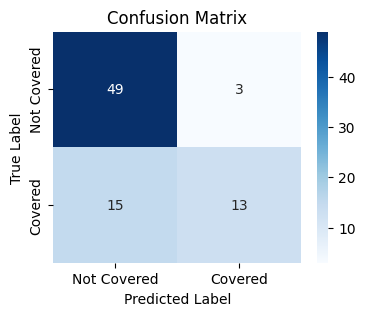

In [46]:
# Create confusion matrix
cm = confusion_matrix(test_coverage, pred_coverage)

# Plot using seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Covered", "Covered"],
    yticklabels=["Not Covered", "Covered"],
)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

Now that the internals of RAG have no secret for you, you can of course use the implementation of libraries such as [langchain](https://python.langchain.com/docs/tutorials/rag/) or [llamaindex](https://docs.llamaindex.ai/en/stable/understanding/putting_it_all_together/q_and_a/#semantic-search) to benefits from all the existing integration with other tools.

And with the saved time, make sure to also evaluate the retrieval itself! Depending on how the chunks used for the annotation of evaluation dataset differs from the ones present in the knowledge database, it's might not be as straighforward as one may think...